# Mini-project n° 1 - Who painted this picture?

In [1]:
import PIL
from PIL import Image
import os, sys

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna
from optuna.trial import TrialState

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Loading datas

In [3]:
data_path = "./art-challenge/"
if not os.path.isdir(data_path) or not os.listdir(data_path):
    !git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/art-challenge.git
else:
    print("Data already downloaded!")

Cloning into 'art-challenge'...
remote: Enumerating objects: 17127, done.
remote: Counting objects: 100% (4373/4373), done.
remote: Compressing objects: 100% (4367/4367), done.
remote: Total 17127 (delta 36), reused 4251 (delta 6), pack-reused 12754 (from 1)
Receiving objects: 100% (17127/17127), 2.16 GiB | 3.75 MiB/s, done.
Resolving deltas: 100% (170/170), done.
Updating files: 100% (16806/16806), done.


In [4]:
# Reading CSV
artists = pd.read_csv(data_path + "artists.csv")
artists.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


## Exploratory data analysis

Nombre total d'artistes : 50
Nombre total de styles : 31


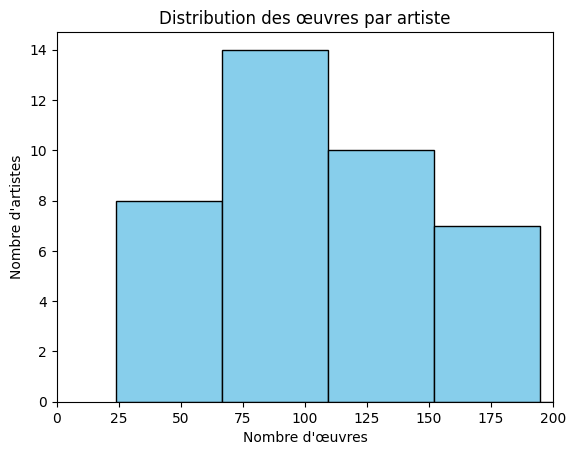

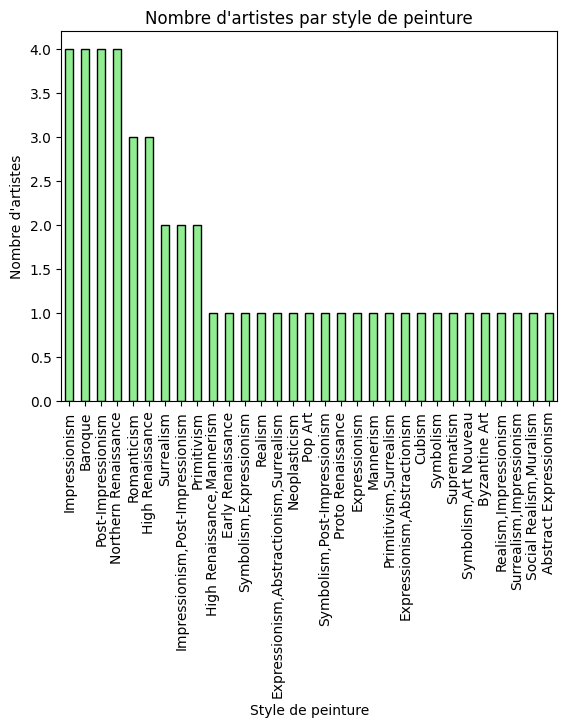

In [10]:
# Analyse descriptive des artistes et des styles
print("Nombre total d'artistes :", artists['name'].nunique())
print("Nombre total de styles :", artists['genre'].nunique())

# Distribution des œuvres par artiste
artists['paintings'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution des œuvres par artiste")
plt.xlabel("Nombre d'œuvres")
plt.ylabel("Nombre d'artistes")
plt.xlim(0, 200)  # Limite de l'axe x
plt.show()

# Distribution des genres de peinture
style_counts = artists['genre'].value_counts()
style_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Nombre d'artistes par style de peinture")
plt.xlabel("Style de peinture")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=90)
plt.show()

In [11]:
# Artiste ayant le plus d'œuvres
artist_max = artists.loc[artists['paintings'].idxmax()]
print("Artiste avec le plus d'œuvres :")
print("Nom :", artist_max['name'])
print("Nombre d'œuvres :", artist_max['paintings'])
print("Genre :", artist_max['genre'])

# Artiste ayant le moins d'œuvres
artist_min = artists.loc[artists['paintings'].idxmin()]
print("\nArtiste avec le moins d'œuvres :")
print("Nom :", artist_min['name'])
print("Nombre d'œuvres :", artist_min['paintings'])
print("Genre :", artist_min['genre'])


Artiste avec le plus d'œuvres :
Nom : Vincent van Gogh
Nombre d'œuvres : 877
Genre : Post-Impressionism

Artiste avec le moins d'œuvres :
Nom : Jackson Pollock
Nombre d'œuvres : 24
Genre : Abstract Expressionism


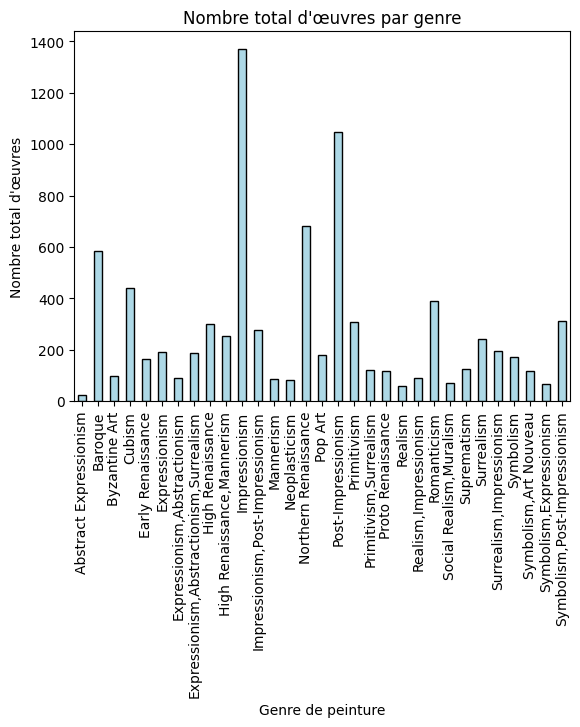

In [12]:
# Calcul du nombre total d'œuvres par genre
genre_paintings = artists.groupby('genre')['paintings'].sum()

# Création de l'histogramme
genre_paintings.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title("Nombre total d'œuvres par genre")
plt.xlabel("Genre de peinture")
plt.ylabel("Nombre total d'œuvres")
plt.xticks(rotation=90)
plt.show()

On voit que la majorité des artistes ont un nombre d'oeuvre compris entre 100 et 200. Nous allons zoomer sur cette zone, de sorte à ce que nous puissions mieux observer les nombres d'oeuvres par artistes.
Néanmoins, on peut noter qu'un artiste  à plus de 800 oeuvres ( Vincent Van Gogh avec 877 oeuvres) et un artiste a 24 oeuvres (Jackson Pollock).
Cependant, en observant le nombre d'artiste par genre, on remarque que J. Pollock est le seul artiste dans sa catégorie, tandis que la catégorie de V. Van Gogh compte le plus d'artiste. De plus, en observant le nombre d'oeuvre par genre, on observe que le post impressionim compte beaucoup plus d'oeuvres que l'Expressionism. Maintenant que la distrbution des genre et des artistes est bien comprises, nous allons nous mener une analyse des périodes de vie des artistes; 

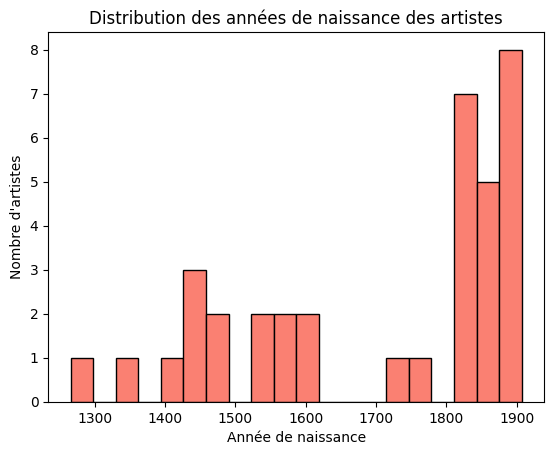

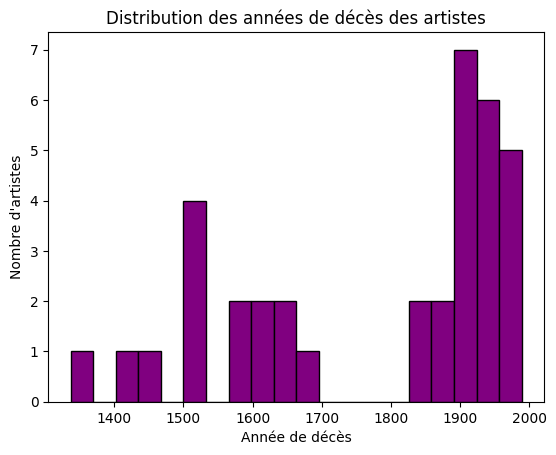

In [13]:
# On sépare la colonne 'year' en deux colonnes : 'birth_year' et 'death_year'
artists[['birth_year', 'death_year']] = artists['years'].str.split('-', expand=True)

# Conversion des nouvelles colonnes en format numérique
artists['birth_year'] = pd.to_numeric(artists['birth_year'], errors='coerce')
artists['death_year'] = pd.to_numeric(artists['death_year'], errors='coerce')

# Histogramme des années de naissance des artistes
artists['birth_year'].dropna().plot(kind='hist', bins=20, color='salmon', edgecolor='black')
plt.title("Distribution des années de naissance des artistes")
plt.xlabel("Année de naissance")
plt.ylabel("Nombre d'artistes")
plt.show()

# Histogramme des années de décès des artistes
artists['death_year'].dropna().plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title("Distribution des années de décès des artistes")
plt.xlabel("Année de décès")
plt.ylabel("Nombre d'artistes")
plt.show()

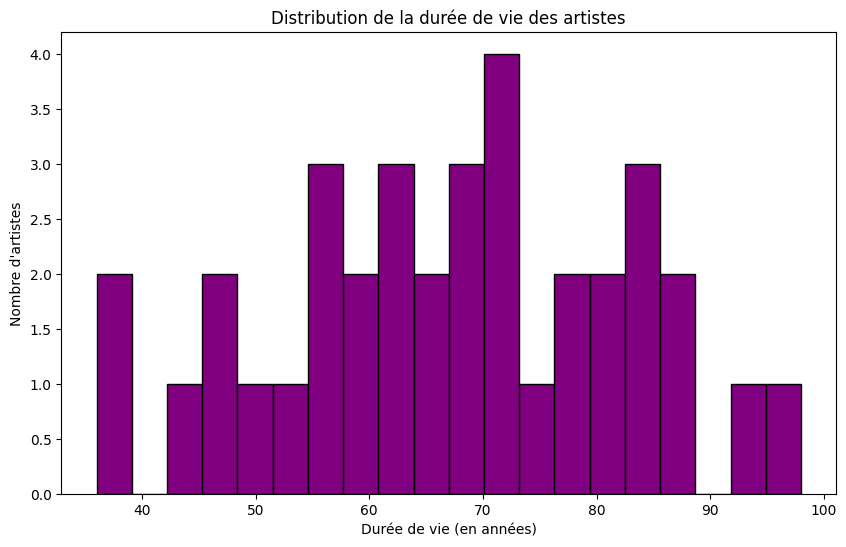

In [14]:
artists['life_duration'] = artists['death_year'] - artists['birth_year']
artists['life_duration'] = artists['life_duration'].dropna()

plt.figure(figsize=(10, 6))
artists['life_duration'].plot(kind='hist', bins=20, color='purple', edgecolor='black')
plt.title('Distribution de la durée de vie des artistes')
plt.xlabel('Durée de vie (en années)')
plt.ylabel('Nombre d\'artistes')
plt.show()

In [16]:
# Identification de l'artiste avec la plus grande durée de vie
longest_lived_artist = artists.loc[artists['life_duration'].idxmax()]
longest_lived_name = longest_lived_artist['name']
longest_lived_paintings = longest_lived_artist['paintings']
longest_lived_duration = longest_lived_artist['life_duration']

# Identification de l'artiste avec la durée de vie la plus courte
shortest_lived_artist = artists.loc[artists['life_duration'].idxmin()]
shortest_lived_name = shortest_lived_artist['name']
shortest_lived_paintings = shortest_lived_artist['paintings']
shortest_lived_duration = shortest_lived_artist['life_duration']

# Affichage des résultats
print(f"Artiste avec la plus grande durée de vie : {longest_lived_name} ({longest_lived_paintings} œuvres, {longest_lived_duration} ans)")
print(f"Artiste avec la durée de vie la plus courte : {shortest_lived_name} ({shortest_lived_paintings} œuvres, {shortest_lived_duration} ans)")


Artiste avec la plus grande durée de vie : Marc Chagall (239 œuvres, 98.0 ans)
Artiste avec la durée de vie la plus courte : Amedeo Modigliani (193 œuvres, 36.0 ans)


In [17]:
correlation = artists['life_duration'].corr(artists['paintings'])
print(f"Corrélation entre durée de vie et nombre d’œuvres : {correlation}")

Corrélation entre durée de vie et nombre d’œuvres : 0.33447442133662464


Nous observons que la majorité des artistes ont émergé à partir de 1800. 

Nombre d'artistes par nationalité :
nationality
French                      13
Italian                      8
Spanish                      5
Russian                      4
Dutch                        4
Flemish                      3
Mexican                      2
American                     2
Belgian                      1
Austrian                     1
Spanish,Greek                1
German                       1
French,British               1
French,Jewish,Belarusian     1
British                      1
Norwegian                    1
German,Swiss                 1
Name: count, dtype: int64


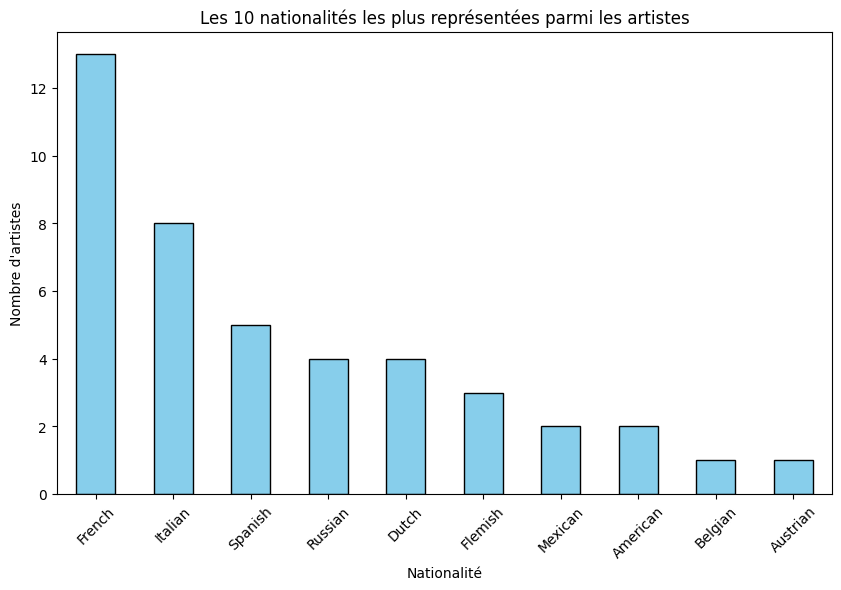

Nationalité la plus représentée : French (13 artistes)
Nationalité la moins représentée : Belgian (1 artiste(s))


In [18]:
# 1. Distribution des nationalités
nationality_counts = artists['nationality'].value_counts()
print("Nombre d'artistes par nationalité :")
print(nationality_counts)

# 2. Visualisation des 10 nationalités les plus représentées
top_nationalities = nationality_counts.head(10)
plt.figure(figsize=(10, 6))
top_nationalities.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 nationalités les plus représentées parmi les artistes")
plt.xlabel("Nationalité")
plt.ylabel("Nombre d'artistes")
plt.xticks(rotation=45)
plt.show()

# 3. Nationalités les plus et les moins représentées
most_represented_nationality = nationality_counts.idxmax()
least_represented_nationality = nationality_counts.idxmin()

print(f"Nationalité la plus représentée : {most_represented_nationality} ({nationality_counts.max()} artistes)")
print(f"Nationalité la moins représentée : {least_represented_nationality} ({nationality_counts.min()} artiste(s))")


Nombre d'œuvres par pays :
nationality
French                      2120
Dutch                       1360
Spanish                     1099
Italian                     1087
Russian                      484
Flemish                      356
German                       328
French,British               259
French,Jewish,Belarusian     239
American                     205
Belgian                      194
Mexican                      190
German,Swiss                 188
Austrian                     117
Spanish,Greek                 87
Norwegian                     67
British                       66
Name: paintings, dtype: int64


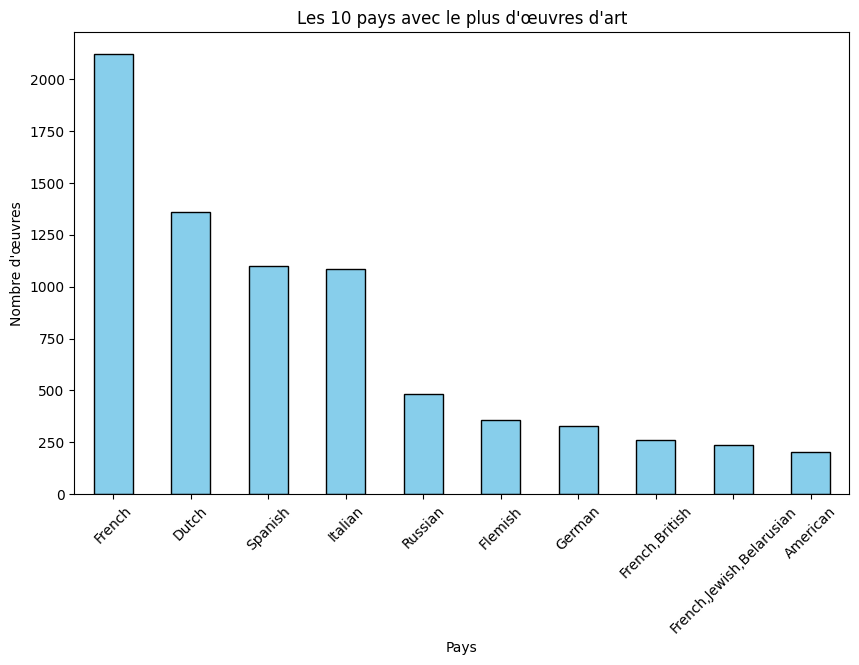

Pays avec le plus d'œuvres : French (2120 œuvres)
Pays avec le moins d'œuvres : British (66 œuvre(s))


In [19]:
# 1. Groupement par nationalité et somme des œuvres par pays
country_paintings = artists.groupby('nationality')['paintings'].sum().sort_values(ascending=False)

print("Nombre d'œuvres par pays :")
print(country_paintings)

# 2. Visualisation des 10 pays les plus représentés en termes d'œuvres
top_countries = country_paintings.head(10)
plt.figure(figsize=(10, 6))
top_countries.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Les 10 pays avec le plus d'œuvres d'art")
plt.xlabel("Pays")
plt.ylabel("Nombre d'œuvres")
plt.xticks(rotation=45)
plt.show()

# 3. Pays avec le plus et le moins d'œuvres
most_paintings_country = country_paintings.idxmax()
least_paintings_country = country_paintings.idxmin()

print(f"Pays avec le plus d'œuvres : {most_paintings_country} ({country_paintings.max()} œuvres)")
print(f"Pays avec le moins d'œuvres : {least_paintings_country} ({country_paintings.min()} œuvre(s))")

Nous observons que la majorité des artistes sont français ou italien, tandis que les artistes les moins nombeux sont orginaires de Belgique, d'Autriche, ...
En outre, nous observons que la France est le pays contenant le plus d'oeuvres, suivi de l'Allemagne. L'Italie arrive en 4ème position, alors qu'elle compte deux fois plus d'artistes que l'Allemagne (4 artistes). Cela nous montre qu'un nombre plus élevé d'artiste dans un pays n'implique pas forcément un plus grand nombre d'oeuvres produites par ces artistes.

## Global params

In [20]:
BATCH_SIZE = 32
EPOCHS = 3

# For HQ images only
IMAGE_HQ_SIZE = 224
MEAN_HQ = [0.485, 0.456, 0.406]
STD_HQ = [0.229, 0.224, 0.225]
TRANSFORM_HQ = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),  # Interpolate
    #transforms.Pad((32, 32, 32, 32)),  # Padding
    transforms.CenterCrop(224),  # Center
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN_HQ, std=STD_HQ)
])

## Creating LQ images loaders

In [21]:
# Loading LQ images
images_lq_path = data_path + "images_lq/"
images_filename = os.listdir(images_lq_path)

list_name = []

for filename in images_filename:
    parts = filename.split('_')
    if len(parts) > 2:
        name_surname = f"{parts[0]} {parts[1]}"
    elif len(parts) == 2:  # "Name_xxx" format
        name_surname = parts[0]  # Only Name
    list_name.append(name_surname)

In [22]:
if len(images_filename) == len(list_name):
    total_lq_df = pd.DataFrame({
        'filename': images_filename,  # Liste des noms de fichiers
        'artist': list_name,          # Liste des artistes pour chaque peinture
    })
    print("DataFrame created successfully!")
else:
    print("Error: The lists have different lengths.")

DataFrame created successfully!


In [23]:
# Prints df if previously created
total_lq_df.head()

,filename,artist
0,William_Turner_29.jpg,William Turner
1,Pieter_Bruegel_98.jpg,Pieter Bruegel
2,Pierre-Auguste_Renoir_245.jpg,Pierre-Auguste Renoir
3,Salvador_Dali_107.jpg,Salvador Dali
4,Alfred_Sisley_51.jpg,Alfred Sisley


In [24]:
IMAGE_LQ_SIZE = 64
DATASET_LQ_SIZE = len(images_filename)
CHANNELS = 3

def load_image_as_rgb_matrices(image_name):    
    img = Image.open(images_lq_path + image_name)
    img = img.resize((IMAGE_LQ_SIZE, IMAGE_LQ_SIZE))  
    img = img.convert('RGB')
    return np.array(img)

x = np.zeros((DATASET_LQ_SIZE, IMAGE_LQ_SIZE, IMAGE_LQ_SIZE, CHANNELS))
for i in range(DATASET_LQ_SIZE):
    x[i] = load_image_as_rgb_matrices(images_filename[i])

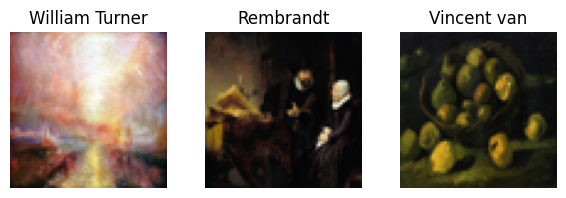

In [25]:
# Few plots
number_of_plots = 3
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(number_of_plots * 2, 2))

for i in range(number_of_plots):
    axes[i].imshow(x[i*100]/255.0)
    axes[i].axis('off')
    axes[i].set_title(f"{list_name[i*100]}")
    
plt.tight_layout()
plt.show()

In [26]:
# All the artists
classes = np.array(list(set(total_lq_df['artist'])))
classes_as_int = np.array([np.where(classes == artist)[0][0] for artist in total_lq_df['artist']])

x_train, x_test_val, y_train, y_test_val = train_test_split(
    np.transpose(x, (0, 3, 1, 2)),  classes_as_int, test_size=0.2, random_state=42
)

x_test, x_val, y_test, y_val = train_test_split(
    x_test_val, y_test_val, test_size=0.5, random_state=42
)

# Normalize images
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset_lq = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset_lq = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset_lq = TensorDataset(x_test_tensor, y_test_tensor)

train_loader_lq = DataLoader(train_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_lq = DataLoader(val_dataset_lq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lq = DataLoader(test_dataset_lq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_lq)}")
print(f"Validation dataset size: {len(val_dataset_lq)}")
print(f"Test dataset size: {len(test_dataset_lq)}")

Train dataset size: 6684
Validation dataset size: 836
Test dataset size: 835


## Creating HQ images loaders

In [58]:
# Loading HQ images
gc = "./art-challenge/images_hq"
dataset_hq = datasets.ImageFolder(root=gc, transform=TRANSFORM_HQ)
DATASET_HQ_SIZE = len(dataset_hq)
CLASS_TO_IDX_HQ = dataset_hq.class_to_idx
IDX_TO_CLASS_HQ = {idx: name for name, idx in CLASS_TO_IDX_HQ.items()}

In [59]:
train_size = int(0.8 * DATASET_HQ_SIZE)  # 70% 
val_size = int(0.1 * DATASET_HQ_SIZE)   # 15% 
test_size = DATASET_HQ_SIZE - train_size - val_size

train_dataset_hq, val_dataset_hq, test_dataset_hq = random_split(dataset_hq, [train_size, val_size, test_size])

train_loader_hq = DataLoader(train_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
val_loader_hq = DataLoader(val_dataset_hq, batch_size=BATCH_SIZE, shuffle=True)
test_loader_hq = DataLoader(test_dataset_hq, batch_size=1, shuffle=False)

print(f"Train dataset size: {len(train_dataset_hq)}")
print(f"Validation dataset size: {len(val_dataset_hq)}")
print(f"Test dataset size: {len(test_dataset_hq)}")

Train dataset size: 6756
Validation dataset size: 844
Test dataset size: 846


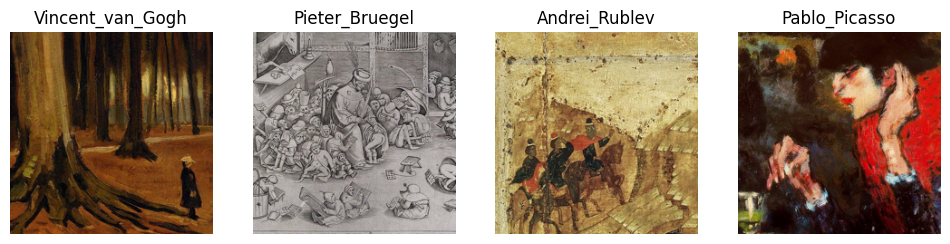

In [61]:
def show_images(images, labels, nb_plots = 4):
    if not nb_plots <= images.shape[0]:
        return
        
    images = images.permute(0, 2, 3, 1)  # From (batch, C, H, W) to (batch, H, W, C)
    
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    images = images * std + mean
    
    plt.figure(figsize=(12, 8))
    for i in range(nb_plots):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')
        plt.title(f'{IDX_TO_CLASS_HQ[labels[i].item()]}')
    plt.show()

# Print few training images
images, labels = next(iter(train_loader_hq))
show_images(images, labels)

## Training and Optimization Part

In [62]:
NUM_CLASSES = len(dataset_hq.classes) # Same value for lQ dataset
DROPOUT_RATE = 0.4
MODEL_PATH = "cnn_weights.pth"

def get_model(name='resnet18', weights='IMAGENET1K_V1', verbose=False):
    model = getattr(models, name)(weights=weights)
    model.fc = nn.Sequential(
        nn.Dropout(p=DROPOUT_RATE),                  
        nn.Linear(model.fc.in_features, NUM_CLASSES)
    ) 

    if verbose:
        trainable_params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable_params}')
        
    return model

In [63]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs=EPOCHS, save_model=False, model_path=MODEL_PATH):
    # Training of the model
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        total_train_samples = 0
        correct_train = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            
            # FB
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # BW
            loss.backward()
            optimizer.step()
            
            # Do not need to apply softmax manually -> this order will be the same
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()

            train_loss += loss.item()
            total_train_samples += images.size(0)
        
        train_loss = train_loss / total_train_samples
        train_accuracy = correct_train / total_train_samples

        # Validation
        model.eval()
        val_loss = 0.0
        total_val_samples = 0
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                total_val_samples += images.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
        
        val_loss = val_loss / total_val_samples
        val_accuracy = correct_val / total_val_samples
        
        # Train accuracy could be used to check if the network learns something
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    if save_model:
        torch.save(model.state_dict(), model_path)    

In [64]:
def test(test_loader, model_path=MODEL_PATH):
    model = get_model(weights=None)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE))
    model = model.to(DEVICE)

    # Validation
    model.eval()
    test_loss = 0.0
    total_test_samples = 0
    correct_test = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
                
            outputs = model(images)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            total_test_samples += images.size(0)
                
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == labels).sum().item()
        
        test_loss = test_loss / total_test_samples
        test_accuracy = correct_test / total_test_samples

        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

In [65]:
# Here we use Optuna to optimize the best hyper-params
# Long time execution...
# See https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
def objective(trial):
    # Define the model
    model = get_model()
    model = model.to(DEVICE)

    # The different parameters we're trying to improve
    fc_lr = trial.suggest_float("fc_lr", 1e-4, 1e-2, log=True)  
    base_lr = trial.suggest_float("base_lr", 1e-6, 1e-4, log=True)

    base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
    # Init optimizer
    optimizer = optim.Adam([
        {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
        {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
    ])

    # Loss
    criterion = nn.CrossEntropyLoss(reduction='sum')

    train(model, criterion, optimizer, train_loader_hq, val_loader_hq)
    
    trial.report(val_accuracy, epoch)

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return val_accuracy

In [ ]:
# Default sampler used: https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [50]:
# Define the model
model = get_model()
model = model.to(DEVICE)

# The best values found previously
fc_lr = 6.47e-4  
base_lr = 8.587e-5

base_params = [p for name, p in model.named_parameters() if "fc" not in name]    
# Init optimizer
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': fc_lr},      # LR for fully connected layer
    {'params': base_params, 'lr': base_lr}               # LR for pretrained layers
])

# Loss
criterion = nn.CrossEntropyLoss(reduction='sum')

train(model, criterion, optimizer, train_loader_hq, val_loader_hq, epochs=5, save_model=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 1/5, Train Loss: 2.2968, Train Accuracy: 0.4174, Val Loss: 1.3982, Val Accuracy: 0.6280


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.04it/s]


Epoch 2/5, Train Loss: 1.0244, Train Accuracy: 0.7238, Val Loss: 1.0689, Val Accuracy: 0.7145


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.05it/s]


Epoch 3/5, Train Loss: 0.5031, Train Accuracy: 0.8726, Val Loss: 0.9935, Val Accuracy: 0.7239


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.06it/s]


Epoch 4/5, Train Loss: 0.2159, Train Accuracy: 0.9557, Val Loss: 0.9414, Val Accuracy: 0.7453


100%|███████████████████████████████████████████████████████████████████████████████████| 27/27 [00:25<00:00,  1.06it/s]

Epoch 5/5, Train Loss: 0.0948, Train Accuracy: 0.9871, Val Loss: 0.9122, Val Accuracy: 0.7583


In [57]:
loss, acc = test(test_loader_hq)

100%|█████████████████████████████████████████████████████████████████████████████████| 846/846 [00:23<00:00, 36.59it/s]

Test Loss: 0.8678, Test Accuracy: 0.7565
